# Gear Detection using Kernel Density Estimation

In [8]:
import pickle
import numpy as np
import pandas as pd
data_dir = "../Data/OBD_Data_only/"

"""
Change the below variables for a separate car and also dont forget to update the boundary of points in the
kernel estimation graph
"""
obddata = pd.read_csv("1.csv", index_col=0)

<IPython.core.display.Javascript object>


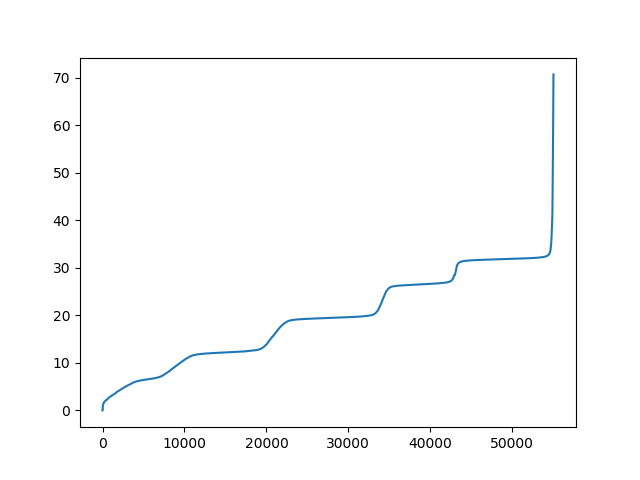

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Get the ratio of the speed and the rpm 
df_ratio = obddata['speed'] / obddata['rpm']
#Fill values equal to na with 0 since we dont care about points 0 speed since 
# it corresponds to stationary vehicle which doesn't help in further analysis
df_ratio = df_ratio.fillna(0)
df_ratio = df_ratio[df_ratio != 0]
# Scale the ratio up by 1000 to be able to make sense of the plot
df_ratio = df_ratio*1000
# Replace inf values that arise due to 0 rpm and set them to 0 since further operations may give errors on inf or nan
df_ratio.replace(np.inf, np.nan).fillna(0)
df_ratio[df_ratio > 80] = 0
# sorted_data is the df_ratio in sorted form for easier analysis of graph
sorted_data = df_ratio.sort_values().reset_index(drop=True)
plt.plot(sorted_data)

<IPython.core.display.Javascript object>


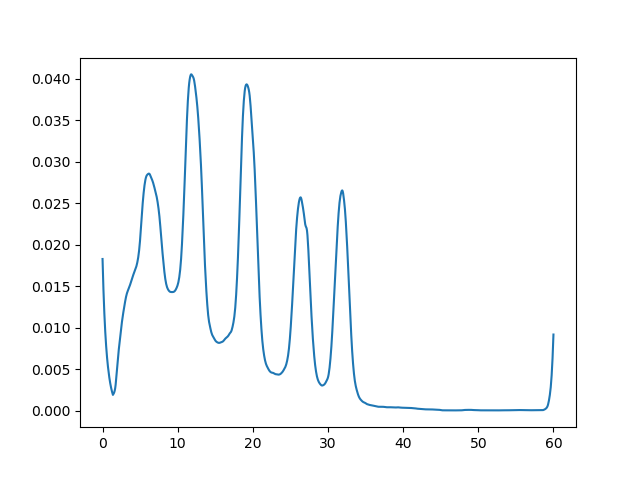

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.signal import savgol_filter

#Smoothening using the convolution method
"""
Smoothening Function which uses convolution with the window size equal to 
the box_points i.e. the square matrix has box_points number of columns and rows
Increasing the number of box_pts allows for a greater smoothening i.e. more of blurring
"""

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

"""
X_plot has the X values that are needed to be plot on the histogram or kernel estimation curve, taken as
1000 points between 0 and 50 since 
"""

"""
Add another dimension to the arrays since kde requires an axis
The values in the linespace are chosen so that all the ratio values for the gears have enough points involved
Also the number of points can be increased to give a more sharp and precise graph
"""
"""
The Value for the second boundary set according to the car
"""
X_plot = np.linspace(0, 60, 1000)[:, np.newaxis]
sorted_data_kernel_fitted = sorted_data[:, np.newaxis]

"""
Apply kde using the Gaussian kernel and with a bandwith of 0.1. The bandwith is a tuning parameter which determines 
the standard deviation of the kernels that are being placed in place of each point. Smaller the value more the 
sharpness in the curves. Kernel could use the tophat kernel but didnt see much of a difference
"""
kde = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(sorted_data_kernel_fitted)
"""
Get the logarithmic scores for the points corresponding to the X_plot this is in the log_dens list
"""
log_dens = kde.score_samples(X_plot)

# Choose which smoothening method to use
# Uncomment below line for unsmoothened data
# smooth_log_dens = log_dens

# Uncomment below line to use the smooth function defined above which uses the convolution method
smooth_log_dens = smooth(log_dens, 47)

# Uncomment below line to use the savitzky_golay function
# smooth_log_dens = savgol_filter(log_dens, 19, 4)

# Plot the actual kernel density estimate graph after it has been smoothened
plt.plot(X_plot[:, 0], np.exp(smooth_log_dens))


In [11]:
#Finding the local minima in density
from scipy.signal import argrelextrema

"""
Get the local minimas index from the smooth_log_dens values and store it in local_min_ind
and the actual minima points in the local_min list
"""
local_min_ind = argrelextrema(smooth_log_dens, np.less)[0]
local_min = X_plot[local_min_ind]


"""
Filter the values with absolute probability less than 0.001 : this parameter can be updated to 
remove as many unneccessary points : Change needed based on the number of trips since many gears
will be used over a period of time
"""

local_min_ind_filtered = list(filter(lambda x : np.exp(smooth_log_dens[x]) >= 0.001, local_min_ind))
local_min_filtered = local_min 
# Comment next line for non filtered data
# local_min_filtered = X_plot[local_min_ind_filtered]

"""
Flatten the list to get values in a single list
"""
local_min_filtered = [x[0] for x in local_min_filtered]
"""
Convert the above list to a series so that we could filter based on the difference too
"""
local_min_filtered_series = pd.Series(local_min_filtered)
"""
Add a dummy 0 at the start to account for the first point 
"""
local_min_filtered_series = pd.Series([0]).append(local_min_filtered_series, ignore_index = True)
local_min_filtered_series = local_min_filtered_series[local_min_filtered_series.diff() > 3].reset_index(drop=True)

"""
Convert it back to a list
"""
local_min_filtered = pd.Series.tolist(local_min_filtered_series)

print(local_min_filtered)

## Use these values as boundaries for the different gears

[9.24924924924925, 15.495495495495495, 23.363363363363362, 29.24924924924925, 36.87687687687688]


In [12]:
"""
Similar to the above
"""
#Finding the local maxima in density
from scipy.signal import argrelextrema

local_max_ind = argrelextrema(smooth_log_dens, np.greater)[0]
local_max = X_plot[local_max_ind]
local_max = [x[0] for x in local_max]

local_max_ind_filtered = list(filter(lambda x : np.exp(smooth_log_dens[x]) >= 0.008, local_max_ind))

local_max_filtered = X_plot[local_max_ind_filtered]
local_max_filtered = [x[0] for x in local_max_filtered]

# print(local_max)

local_max_filtered_series = pd.Series(local_max_filtered)
local_max_filtered_series = pd.Series([0]).append(local_max_filtered_series, ignore_index = True)
local_max_filtered_series = local_max_filtered_series[local_max_filtered_series.diff() > 2].reset_index(drop=True)

local_max_filtered = pd.Series.tolist(local_max_filtered_series)
print(local_max_filtered)

[6.186186186186186, 11.831831831831831, 19.15915915915916, 26.366366366366368, 31.89189189189189]
